In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bsoup
from thefuzz import fuzz

from typing import Any, List, Dict, Tuple, Optional
from tqdm.notebook import tqdm
from tqdm import tqdm

import constants, index_tools, data_tools

from utilities import *

In [2]:
DEV_MODE = True

UK_BIOBANK_DATA_CSV_PATH = constants.UK_BIOBANK_DEV_DATA_CSV if DEV_MODE else constants.UK_BIOBANK_DATA_CSV

# Data Index

In [3]:
biobank_index_full = index_tools.load_index()

In [4]:
biobank_index_full = index_tools.add_udi_names_to_index(biobank_index_full)
udi_map = index_tools.UDIMap(biobank_index_full)

# Load BioBank Data

In [10]:
biobank_data_full = data_tools.load_biobank_data(UK_BIOBANK_DATA_CSV_PATH, udi_map)
biobank_index_full = index_tools.add_biobank_info_to_index(biobank_index_full, biobank_data_full)
display(biobank_data_full.head())

UK BioBank Data Loaded.
Size: 9999 rows x 3973 columns


,eid,spirometry_method,spirometry_method_1.0,spirometry_method_2.0,sex,birth_year,blood_sample_attempted,blood_sample_attempted_1.0,blood_sample_attempted_2.0,bp_device,...,important_unlabeled_32,important_unlabeled_33,patient_classification_on_admission,patient_classification_on_admission_0.1,patient_classification_on_admission_0.2,patient_classification_on_admission_0.3,patient_classification_on_admission_0.4,patient_classification_on_admission_0.5,patient_classification_on_admission_0.6,important_unlabeled_34
0,1000015,0.0,NaN,NaN,1,1963,1.0,NaN,NaN,157.0,...,2.0,3.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,5.0
1,1000027,0.0,NaN,NaN,0,1956,1.0,NaN,NaN,3157.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1000039,NaN,NaN,NaN,0,1948,1.0,NaN,NaN,1048.0,...,13.0,15.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,19.0
3,1000040,0.0,NaN,NaN,1,1947,1.0,NaN,NaN,1044.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
4,1000053,0.0,NaN,0.0,0,1962,1.0,NaN,1.0,162.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean + Reduce feature set

In [15]:
biobank_data = data_tools.clean_biobank_data(biobank_data_full)

reduced_feature_set = data_tools.create_reduced_feature_set(biobank_data_full)


biobank_index = biobank_index_full.loc[biobank_index_full["name"].isin(reduced_feature_set)].reset_index()
biobank_data = biobank_data_full[reduced_feature_set]

In [16]:
biobank_data.shape

(9999, 542)

In [17]:
biobank_index

,index,column,udi,count,type,description,data_code,data_n_members,data_type,data_structure,name,counts,frequency
0,0,0,eid,502543,Sequence,Encoded anonymised participant ID,None,None,None,None,eid,9999,1.000000
1,1,1,23-0.0,456606,Categorical (single),Spirometry method,100270,5,integer-valued,simple_list,spirometry_method,9056,0.905691
2,4,4,31-0.0,502543,Categorical (single),Sex,9,2,integer-valued,simple_list,sex,9999,1.000000
3,5,5,34-0.0,502543,Integer,Year of birth,None,None,None,None,birth_year,9999,1.000000
4,6,6,35-0.0,501328,Categorical (single),Was blood sampling attempted,7,2,integer-valued,simple_list,blood_sample_attempted,9978,0.997900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,3962,3962,41235-0.0,330471,Integer,Spells in hospital,None,None,None,None,hospital_spells,6525,0.652565
538,3963,3963,41240-0.0,277019,Integer,"Episodes containing ""Patient classification on...",None,None,None,None,important_unlabeled_32,5456,0.545655
539,3964,3964,41241-0.0,305421,Integer,"Episodes containing ""Intended management of pa...",None,None,None,None,important_unlabeled_33,6028,0.602860
540,3965,3965,41247-0.0,277019,Categorical (multiple),Patient classification on admission (recoded),266,13,integer-valued,hierarchical_tree,patient_classification_on_admission,5456,0.545655


# Feature Exploration

In [18]:
feature_data = {"feature": [], "feature_samples": [], "n_unique": []}

for column in tqdm(biobank_data.columns, desc="Analyzing features", unit=" feature"):
    unique_features = biobank_data[column].unique()
    feature_data["feature_samples"].append(np.random.choice(unique_features, min(5, len(unique_features))))
    feature_data["feature"].append(column)
    feature_data["n_unique"].append(len(unique_features))
    
feature_data = pd.DataFrame(feature_data)

Analyzing features: 100%|██████████| 542/542 [00:00<00:00, 5584.01 feature/s]


In [19]:
UK_BIOBANK_FEATURE_VALUE_REMAPPING = {
    "sex": ["female", "male"]
}

# Feature Index EDA

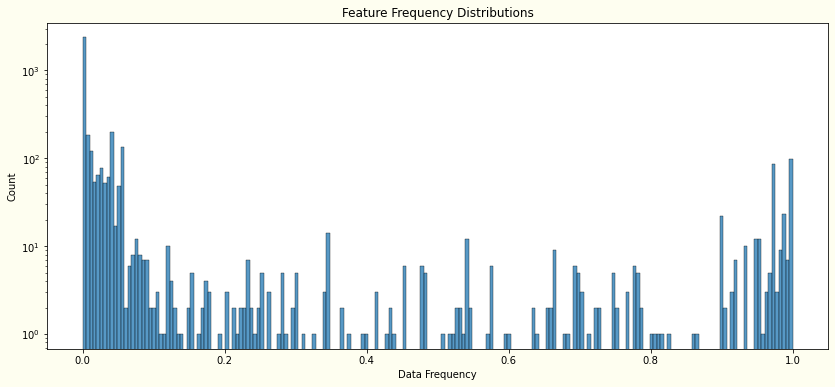

In [154]:
fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fefef0")
sns.histplot(biobank_index_full["frequency"], ax=ax)
ax.set_yscale("log")
add_plt_labels(ax, "Data Frequency", "Count", "Feature Frequency Distributions")
plt.show()
fig.tight_layout()
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("feature_frequency_distribution.png"), facecolor="#fefef0")

# actual EDA

In [150]:
cancer_biobank = biobank_data.loc[~biobank_data["cancer_code"].isna()]

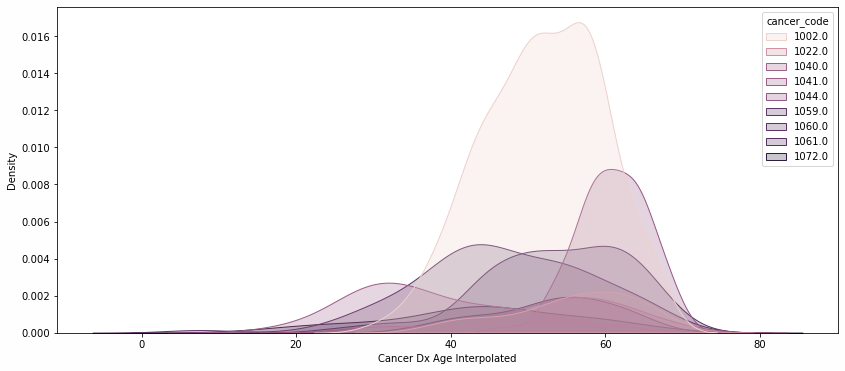

In [151]:
cancer_codes, counts = np.unique(cancer_biobank["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[counts > 20]
common_cancer_biobank = cancer_biobank.loc[cancer_biobank["cancer_code"].isin(common_cancer_codes)]


fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fefefe")
sns.kdeplot(data=common_cancer_biobank, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax, shade=True)
add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_onset_age.png"), facecolor="#fefefe")

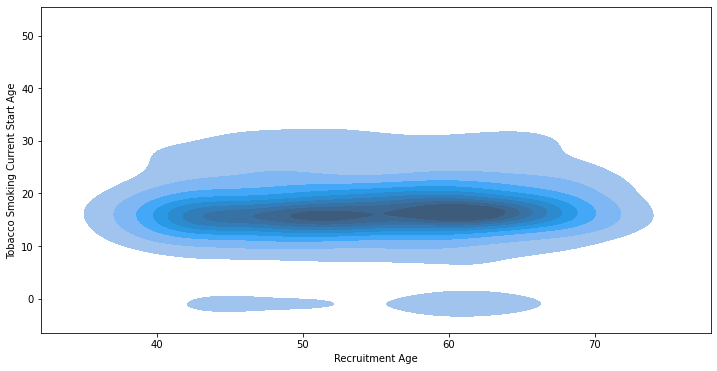

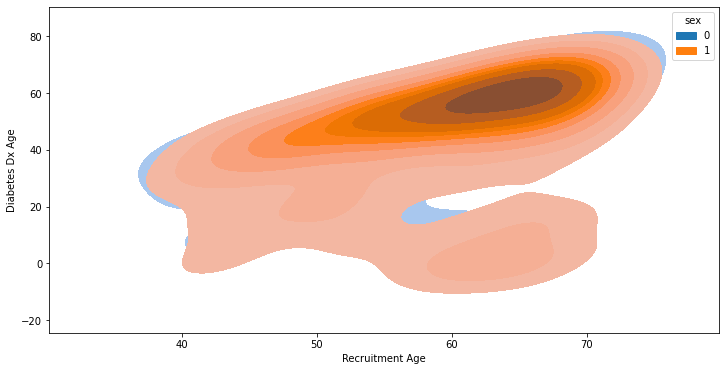

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
y = "tobacco_smoking_current_start_age"
x = "recruitment_age"

sns.kdeplot(data=biobank_data, y=y, x=x, ax=ax, fill=True)
add_plt_labels(ax, x, y)

y, x = "diabetes_dx_age", "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=biobank_data, x=x, y=y, hue="sex", ax=ax, fill=True)
add_plt_labels(ax, x, y)

<AxesSubplot:xlabel='tobacco_smoking_current_start_age', ylabel='Count'>

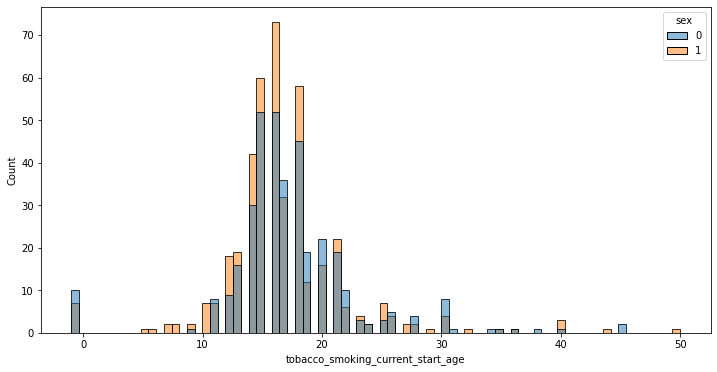

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x="tobacco_smoking_current_start_age", hue="sex",  ax=ax)

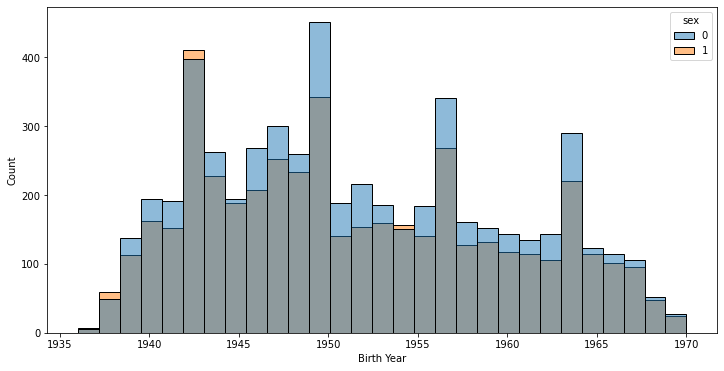

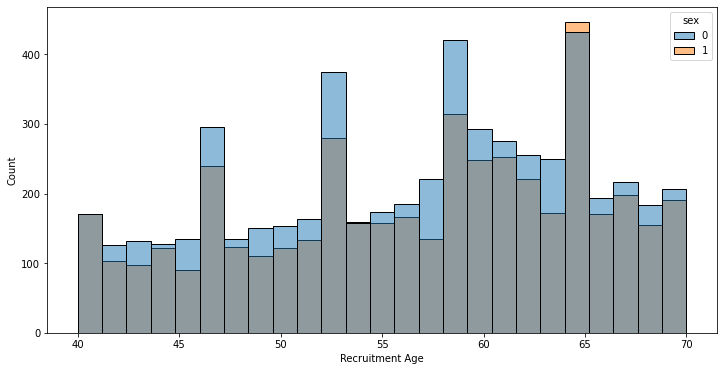

In [37]:
x, hue = "birth_year", "sex"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")

x = "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")